# DiploDatos Kaggle Competition

Presentamos un código creado como ejemplo de base para la competición.

Deben:

- Explorar los datos y aprender de ellos.
- Probar diferentes modelos y ver cuáles ajustan mejor dado los datos.
- **Obtener una accuracy mejor que la que se presenta en este ejemplo.**
- Tratar de obtener la accuracy más alta posible!
- Discutir la elección de modelo.

El análisis exploratorio y el preprocesamiento de los datos queda a libertad de cada grupo y no deben quedarse con este simple ejemplo.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model, tree, ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.impute import KNNImputer
from imblearn.combine import SMOTETomek

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier

## Leer el dataset

### Train

Cargamos los datos de entrenamiento que vamos a utilizar para generar nuestro modelo.

In [70]:
train_df = pd.read_csv('https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/Pr%C3%A1ctico/diabetes_prediction_dataset_train-labeled.csv')
print(train_df.shape)
print(train_df.describe())

(95000, 10)
             patient           age  hypertension  heart_disease           bmi  \
count   95000.000000  95000.000000  95000.000000   95000.000000  95000.000000   
mean    50016.501389     41.935269      0.075074       0.039463     27.320879   
std     28868.357071     22.514788      0.263512       0.194695      6.626335   
min         1.000000      0.080000      0.000000       0.000000     10.010000   
25%     25021.750000     24.000000      0.000000       0.000000     23.650000   
50%     50024.000000     43.000000      0.000000       0.000000     27.320000   
75%     75024.250000     60.000000      0.000000       0.000000     29.580000   
max    100000.000000     80.000000      1.000000       1.000000     95.690000   

        HbA1c_level  blood_glucose_level      diabetes  
count  95000.000000         95000.000000  95000.000000  
mean       5.527659           138.070537      0.085074  
std        1.070261            40.739962      0.278993  
min        3.500000           

In [71]:
train_df.head()

,patient,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,20432,Male,4.0,0,0,never,19.28,3.5,155,0
1,49682,Female,50.0,0,0,former,27.32,5.7,159,0
2,73886,Female,43.0,0,0,never,21.54,4.5,145,0
3,53144,Male,64.0,0,0,current,28.22,6.0,130,0
4,98507,Male,10.0,0,0,No Info,15.46,6.1,140,0


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95000 entries, 0 to 94999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   patient              95000 non-null  int64  
 1   gender               95000 non-null  object 
 2   age                  95000 non-null  float64
 3   hypertension         95000 non-null  int64  
 4   heart_disease        95000 non-null  int64  
 5   smoking_history      95000 non-null  object 
 6   bmi                  95000 non-null  float64
 7   HbA1c_level          95000 non-null  float64
 8   blood_glucose_level  95000 non-null  int64  
 9   diabetes             95000 non-null  int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 7.2+ MB


Se puede observar que la mayoria de las variables son `int` y `float`, excepto gender y smoking_history que son del tipo `object`

### Test

Cargamos los datos de test. Estos datos son los que van a utilizar para predecir si las personas tienen diabetes y generar alrchivo `submision.csv` para utilizar en la competencia de Kaggle.

In [72]:
test_df = pd.read_csv('https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/Pr%C3%A1ctico/diabetes_prediction_dataset_test.csv')
print(test_df.shape)
print(test_df.describe())

(5000, 10)
            patient          age  hypertension  heart_disease          bmi  \
count   5000.000000  5000.000000   5000.000000    5000.000000  5000.000000   
mean   49696.473600    40.947016      0.070600       0.038600    27.318644   
std    28855.568156    22.537466      0.256181       0.192659     6.832943   
min        7.000000     0.160000      0.000000       0.000000    10.620000   
25%    24720.750000    23.000000      0.000000       0.000000    23.410000   
50%    49522.500000    41.000000      0.000000       0.000000    27.320000   
75%    74686.000000    59.000000      0.000000       0.000000    29.632500   
max    99970.000000    80.000000      1.000000       1.000000    88.760000   

       HbA1c_level  blood_glucose_level  diabetes  
count  5000.000000          5000.000000       0.0  
mean      5.524620           137.821000       NaN  
std       1.078559            40.101933       NaN  
min       3.500000            80.000000       NaN  
25%       4.800000        

In [73]:
test_df.head()

,patient,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,49267,Male,53.0,0,0,never,31.99,4.5,126,NaN
1,82280,Female,22.0,0,0,never,25.96,6.6,130,NaN
2,33216,Female,37.0,0,0,never,22.24,6.2,126,NaN
3,94551,Female,29.0,0,0,not current,31.01,5.0,80,NaN
4,43760,Male,30.0,0,0,ever,28.66,6.6,100,NaN


In [74]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   patient              5000 non-null   int64  
 1   gender               5000 non-null   object 
 2   age                  5000 non-null   float64
 3   hypertension         5000 non-null   int64  
 4   heart_disease        5000 non-null   int64  
 5   smoking_history      5000 non-null   object 
 6   bmi                  5000 non-null   float64
 7   HbA1c_level          5000 non-null   float64
 8   blood_glucose_level  5000 non-null   int64  
 9   diabetes             0 non-null      float64
dtypes: float64(4), int64(4), object(2)
memory usage: 390.8+ KB


El dataset de test corresponde al 5% del total

In [75]:
print(f'Train shape:\t{train_df.shape[0]}')
print(f'Test shape:\t{test_df.shape[0]}')

Train shape:	95000
Test shape:	5000


## Analisis de los datos


Es necesario conocer la variable objetivo del dataset

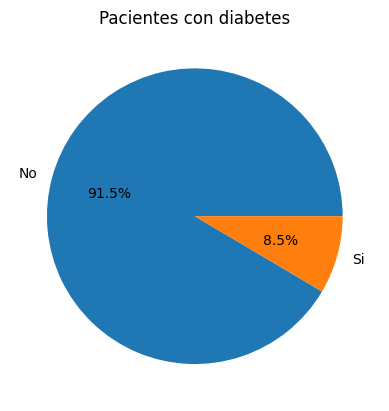

In [ ]:
plt.pie(train_df.diabetes.value_counts(), labels=['No','Si'], autopct='%1.1f%%')
plt.title('Pacientes con diabetes')
plt.show()

Se puede observar que la variable objetivo esta muy desbalanceada. Hay que tener en cuenta esto a la hora de entrenar el modelo. Se crear un histograma por cada variable para ver su compartamiento con respecto a la variable objetivo

### Histogramas

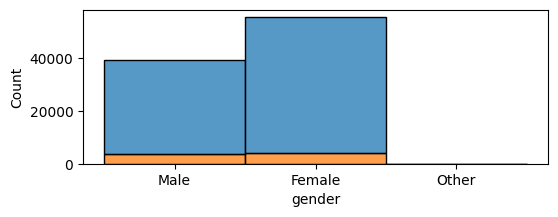

In [ ]:
fig = plt.figure(figsize=(6,2))
sns.histplot(data=train_df, x="gender", hue="diabetes", multiple="stack", bins=50, legend=False)
plt.show()

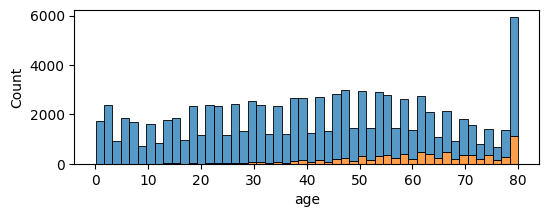

In [ ]:
fig = plt.figure(figsize=(6,2))
sns.histplot(data=train_df, x="age", hue="diabetes", multiple="stack", bins=50, legend=False)
plt.show()

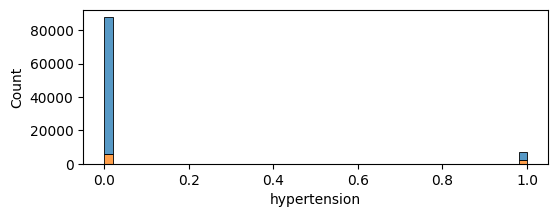

In [ ]:
fig = plt.figure(figsize=(6,2))
sns.histplot(data=train_df, x="hypertension", hue="diabetes", multiple="stack", bins=50, legend=False)
plt.show()

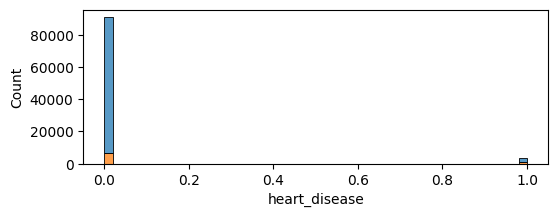

In [ ]:
fig = plt.figure(figsize=(6,2))
sns.histplot(data=train_df, x="heart_disease", hue="diabetes", multiple="stack", bins=50, legend=False)
plt.show()

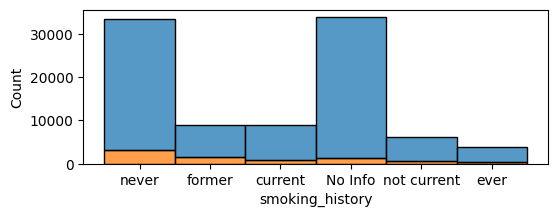

In [ ]:
fig = plt.figure(figsize=(6,2))
sns.histplot(data=train_df, x="smoking_history", hue="diabetes", multiple="stack", bins=50, legend=False)
plt.show()

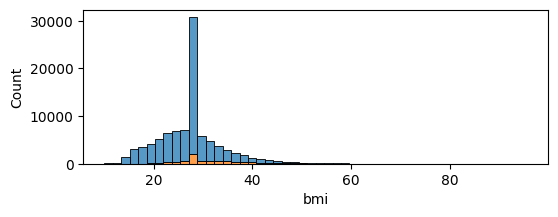

In [ ]:
fig = plt.figure(figsize=(6,2))
sns.histplot(data=train_df, x="bmi", hue="diabetes", multiple="stack", bins=50, legend=False)
plt.show()

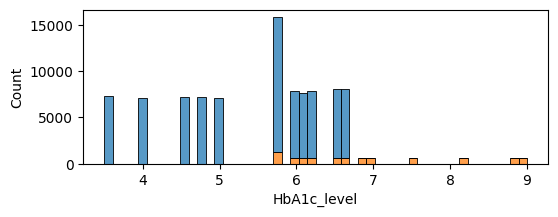

In [ ]:
fig = plt.figure(figsize=(6,2))
sns.histplot(data=train_df, x="HbA1c_level", hue="diabetes", multiple="stack", bins=50, legend=False)
plt.show()

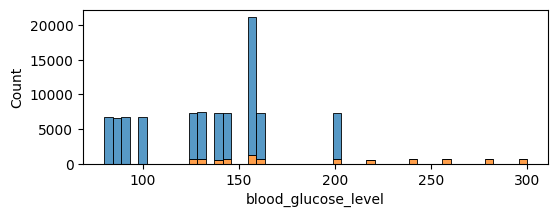

In [ ]:
fig = plt.figure(figsize=(6,2))
sns.histplot(data=train_df, x="blood_glucose_level", hue="diabetes", multiple="stack", bins=50, legend=False)
plt.show()

Luego de obserbar los histogramas se obtienen las siguientes conclusiones:
- age: presenta cierta discrepancia, ya que muestra que la gran mayoria de pacientes tiene 80 años y viendo la distribucion de todas las edades, puede ser erroneo
- bmi: presenta una gran cantidad de datos alrededor de 27, pero esto corresponde a un valor esperado para una persona "saludable"
- smoke_history: se puede observar que la categoria **No_Info**, es decir, datos faltantes tiene una gran cantidad de valores

### Boxplot

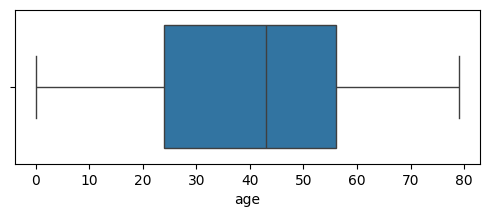

In [ ]:
fig = plt.figure(figsize=(6,2))
sns.boxplot(data=train_df, x="age", legend=False)
plt.show()

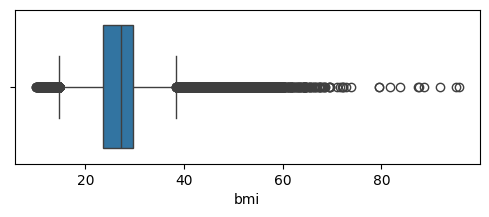

In [ ]:
fig = plt.figure(figsize=(6,2))
sns.boxplot(data=train_df, x="bmi", legend=False)
plt.show()

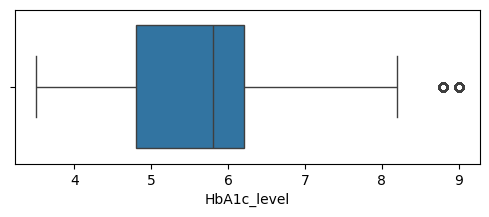

In [ ]:
fig = plt.figure(figsize=(6,2))
sns.boxplot(data=train_df, x="HbA1c_level", legend=False)
plt.show()

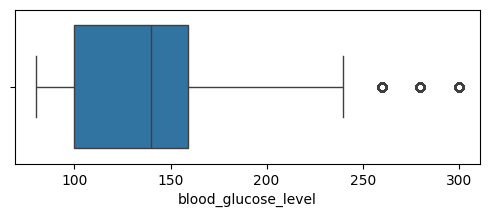

In [ ]:
fig = plt.figure(figsize=(6,2))
sns.boxplot(data=train_df, x="blood_glucose_level", legend=False)
plt.show()

## Preprocesamiento de datos


## Entremiendo del modelo

### Clasificador por votación

Un clasificador de votación es un modelo de aprendizaje automático que adquiere experiencia entrenando en un conjunto de varios modelos y pronostica una salida (clase) basada en la clase con mayor probabilidad de convertirse en la salida.




Se basa en construir un modelo único que aprenda de varios modelos y que pueda predecir en función de la mayoría de votos para cada modelo, en lugar de construir modelos especializados separados y determinar la precisión de cada uno de ellos. Existen principalmente dos tipos diferentes de clasificadores de votación:

- `hard`: la salida prevista es la clase con la mayor cantidad de votos, es decir, la clase con la mayor probabilidad de ser predicha por cada modelo.
- `soft`: las probabilidades promedio de los modelos determinan cuál será la predicción final

Primero se separan los datos

In [113]:
def standard_scaler (df, col_names):
    features = df[col_names]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    df[col_names] = features

    return df

In [115]:
df = standard_scaler(df, ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level'])

In [116]:
X = df.drop('diabetes', axis=1)
y = df['diabetes']

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

A partir de esto se plantean tres modelos:
- AdaBoostClassifier: Un clasificador de boosting adaptativo que ajusta modelos base secuencialmente, ponderando los errores de predicción anteriores
- XGBClassifier: Un clasificador basado en el algoritmo de Gradient Boosting de XGBoost, conocido por su eficiencia y flexibilidad
- LGBMClassifier: Un clasificador basado en el algoritmo de Gradient Boosting de LightGBM, optimizado para velocidad y rendimiento en conjuntos de datos grandes

In [118]:
ada_boost = AdaBoostClassifier(random_state = 42)
xgb = XGBClassifier(random_state = 42)
lgbm = LGBMClassifier(random_state = 42)

Se instancia el clasificador por votacíon mediante `VotingClassifier`

In [119]:
voting_clf = VotingClassifier(
    estimators=[('ada', ada_boost), ('xgb', xgb), ('lgbm', lgbm)],
    voting='soft'
)

voting_clf.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 6483, number of negative: 69517
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 664
[LightGBM] [Info] Number of data points in the train set: 76000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085303 -> initscore=-2.372388
[LightGBM] [Info] Start training from score -2.372388


VotingClassifier(estimators=[('ada', AdaBoostClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=N...
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('lgbm', LGBMClassifier(random_state=42))],
                 voting='soft')

Se ven las métricas del modelo

Accuracy train voting_clf: 97.5671%
Accuracy test voting_clf: 97.1263%


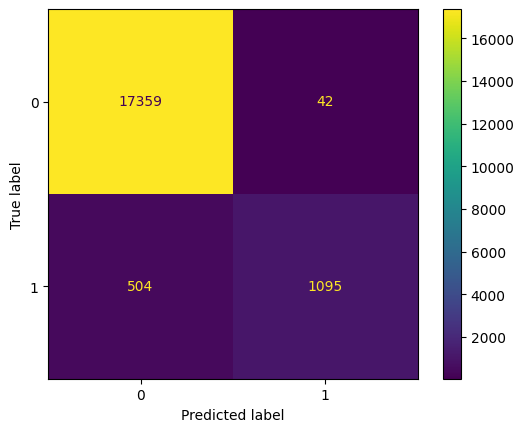

In [120]:
name = 'voting_clf'
train_predictions = voting_clf.predict(X_train)
accuracy = accuracy_score(y_train, train_predictions)
print(f"Accuracy train {name}: %.4f%%" % (accuracy * 100.0))

test_predictions = voting_clf.predict(X_test)
accuracy = accuracy_score(y_test, test_predictions)
print(f"Accuracy test {name}: %.4f%%" % (accuracy * 100.0))
ConfusionMatrixDisplay.from_predictions(y_test, test_predictions)
plt.show()

Se puede obser que la precisión para este caso da menor al baseline `0.97266`


### Submuestreo y Clasficador de votacion

Se crea una copia del dataset de entrenamiento

In [121]:
df = train_df.copy()

Se codifican las variables categoricas

In [122]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
label_encoder = LabelEncoder()

for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

Como se menciono anteriormente, la variable objetivo esta desbalanceda. Para abordar este problema se procede sobremuestrear.


SMOTETomek es una técnica combinada de sobremuestreo y submuestreo para el balanceo de conjuntos de datos desequilibrados. Combina dos métodos:

- SMOTE (Synthetic Minority Over-sampling Technique): Esta técnica genera nuevas muestras sintéticas de la clase minoritaria. Lo hace seleccionando aleatoriamente una muestra de la clase minoritaria y encontrando sus k vecinos más cercanos. Luego, crea un nuevo ejemplo sintético en el espacio entre la muestra seleccionada y uno de sus vecinos.

- Tomek Links: Es una técnica de submuestreo que identifica y elimina parejas de ejemplos (un ejemplo de la clase mayoritaria y otro de la clase minoritaria) que son los vecinos más cercanos entre sí y pertenecen a diferentes clases. Si un par de ejemplos es un Tomek Link, significa que la frontera de decisión entre las clases es ruidosa en ese punto, y eliminando estos ejemplos se puede mejorar la separación entre clases.

Ver [link](https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTETomek.html)

Para aplicar este metodo se debe separa primero el datase

In [123]:
X = df.drop('diabetes', axis=1)
y = df['diabetes']

In [124]:
smote_tomek = SMOTETomek(random_state=42)

X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

resampled_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns),
                          pd.DataFrame(y_resampled, columns=['diabetes'])], axis=1)

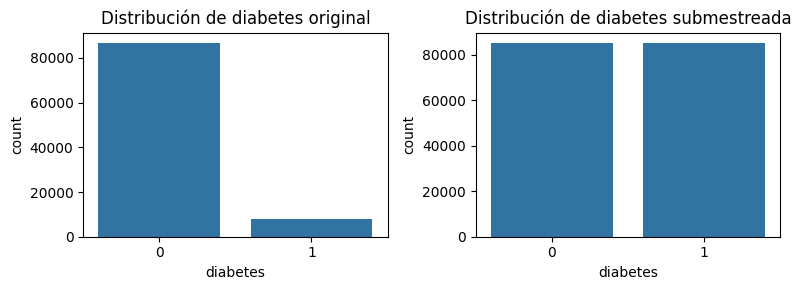

In [125]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

sns.countplot(ax=ax[0], data=df, x='diabetes')
ax[0].set_title('Distribución de diabetes original')

sns.countplot(ax=ax[1], data=resampled_df, x='diabetes')
ax[1].set_title('Distribución de diabetes submestreada')

plt.tight_layout()
plt.show()

Una vez realizado el submuestreo, se procede a dividir los datos

In [126]:
X = resampled_df.drop(columns= 'diabetes')
y = resampled_df['diabetes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Una vez seleccionados los modelos, se crea un clasificador de votacion. El objetivo de este procedimiento es combinar las predicciones de tres clasificadores diferentes en un solo modelo usando un clasificador de votación. Al hacer esto, se espera mejorar la precisión del modelo final al aprovechar las fortalezas de cada clasificador individual.

El parametro `soft` indica que se promedian las probabilidades de los modelos individuales para tomar una decision final

In [127]:
random_state = 6

In [128]:
ada_boost = AdaBoostClassifier(random_state=random_state)
xgb = XGBClassifier(random_state=random_state )
lgbm = LGBMClassifier(random_state=random_state )

In [129]:
voting_clf = VotingClassifier(
    estimators=[('ada', ada_boost), ('xgb', xgb), ('lgbm', lgbm)],
    voting='soft'
)

voting_clf.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 68298, number of negative: 68436
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1213
[LightGBM] [Info] Number of data points in the train set: 136734, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499495 -> initscore=-0.002019
[LightGBM] [Info] Start training from score -0.002019


VotingClassifier(estimators=[('ada', AdaBoostClassifier(random_state=6)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=6, ...)),
                             ('lgbm', LGBMClassifier(random_state=6))],
                 voting='soft')

Accuracy train voting_clf: 98.4327%
Accuracy test voting_clf: 98.2243%


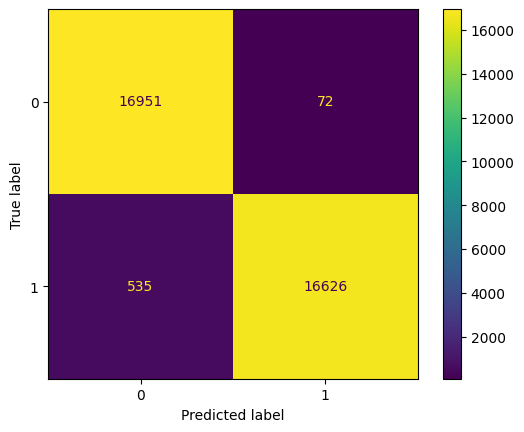

In [130]:
name = 'voting_clf'
train_predictions = voting_clf.predict(X_train)
accuracy = accuracy_score(y_train, train_predictions)
print(f"Accuracy train {name}: %.4f%%" % (accuracy * 100.0))

test_predictions = voting_clf.predict(X_test)
accuracy = accuracy_score(y_test, test_predictions)
print(f"Accuracy test {name}: %.4f%%" % (accuracy * 100.0))
ConfusionMatrixDisplay.from_predictions(y_test, test_predictions)
plt.show()

## Generar la salida para entregar

In [106]:
test_df = pd.read_csv('https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/Pr%C3%A1ctico/diabetes_prediction_dataset_test.csv')

Para poder evaluar nuestra predicción los datos de prueba deben tener exactamente el mismo tratamiento que los datos de entrenamiento

In [107]:
Y_test = test_df.diabetes
PatientId_test = test_df['patient']
#_test = test_df.drop(['patient','diabetes'],axis=1,inplace=True)
X_test = test_df.drop(['diabetes'],axis=1,inplace=True)

In [108]:
X_test = test_df

In [109]:
categorical_columns = X_test.select_dtypes(include=['object']).columns.tolist()
label_encoder = LabelEncoder()

for col in categorical_columns:
    X_test[col] = label_encoder.fit_transform(X_test[col])

In [ ]:
a
cols = X_test.columns
X_test = StandardScaler().fit_transform(X_test)
X_test = pd.DataFrame(X_test, columns=cols)

In [110]:

X_test

,patient,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
0,49267,1,53.0,0,0,4,31.99,4.5,126
1,82280,0,22.0,0,0,4,25.96,6.6,130
2,33216,0,37.0,0,0,4,22.24,6.2,126
3,94551,0,29.0,0,0,5,31.01,5.0,80
4,43760,1,30.0,0,0,2,28.66,6.6,100
...,...,...,...,...,...,...,...,...,...
4995,88540,0,23.0,0,0,4,22.77,6.6,200
4996,26701,0,51.0,0,0,0,27.32,4.0,155
4997,47271,1,79.0,0,0,0,23.80,6.0,126
4998,97941,1,24.0,0,0,4,22.68,6.1,85


Generamos la salida

In [111]:
test_id = PatientId_test
test_pred = np.int64(voting_clf.predict(X_test))

Con el resultado predicho tenemos que generar el archivo `.csv` para subir a la competencia de kaggle:

In [112]:
submission = pd.DataFrame(list(zip(test_id, test_pred)), columns=["patient", "diabetes"])
submission.to_csv("sample_submission.csv", header=True, index=False)

**Suerte!! :D**

# Resultados
## baseline
### Árbol de decisión
- Accuracy train Árbol de decisión: 99.92%
- Accuracy test {name}: 95.16%